# Projet de fin de session
**Fait par :**  
- *Ahmed Letrach* 

## libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
#!pip install shap
#!pip install catboost
import shap
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv


## Functions

In [2]:
def count_unique(ds,col,sort=False):
  data=ds.copy()
  li = list(data[col].unique())
  co = []
  for i in li:
    c = data[data[col]==i].shape[0]
    co.append(c)
  ds1 = {col:li, 'count':co}
  counted = pd.DataFrame(ds1)
  if sort:
    counted.sort_values('count',ascending=False)
  counted.reset_index(drop=True, inplace=True)
  return counted

def missing_values(ds):
  data = ds.copy()
  s = data.isnull().sum()
  total = s.sort_values(ascending=False)
  percent = (s/ds.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total,percent],axis=1,keys=['Total','percent'])
  return missing_data

def getDuplicateColumns(ds):
  duplicateColumnsNames = set()
  for x in range(ds.shape[1]):
    col = ds.iloc[:,x] 
    for y in range(x + 1, ds.shape[1]):
      otherCol = ds.iloc[:,y]
      if col.equals(otherCol):
        duplicateColumnsNames.add(ds.columns.values[y])
  return list(duplicateColumnsNames)

## Import data

In [80]:
# from google.colab import drive
# drive.mount('/content/drive')

In [81]:
# math = pd.read_csv('/content/drive/MyDrive/project_nf21/datamath.csv.xls',sep=';')
# por = pd.read_csv('/content/drive/MyDrive/project_nf21/dataportug.csv.xls',sep=';')
# print(f'shape of math data {math.shape}, and shape of math data {por.shape}')

In [4]:
por = pd.read_csv('dataportug.csv',sep=';')
math = pd.read_csv('datamath.csv',sep=';')
print(f'shape of math data {math.shape}, and shape of math data {por.shape}')

shape of math data (395, 33), and shape of math data (649, 33)


In [5]:
# columns of math data
math.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [84]:
# columns of por data
por.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## merging data (por and math)

In [6]:
math.rename(columns={'absences':'absences_math','G1':'math_G1','G2':'math_G2','G3':'math_G3'},inplace =True)
por.rename(columns={'absences':'absences_por','G1':'por_G1','G2':'por_G2','G3':'por_G3'},inplace =True)

In [7]:
col_j = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']
new_data = math.merge(por,how='inner',on=col_j)
print(f'shape of the merged data :  {new_data.shape}')

shape of the merged data :  (162, 37)


In [8]:
new_data.describe().T.apply(lambda col: col.apply(lambda val: round(val, 2)))

,count,mean,std,min,25%,50%,75%,max
age,162.0,16.48,1.19,15.0,16.00,16.0,17.00,22.0
Medu,162.0,2.77,1.08,0.0,2.00,3.0,4.00,4.0
Fedu,162.0,2.60,1.12,0.0,2.00,3.0,4.00,4.0
traveltime,162.0,1.48,0.74,1.0,1.00,1.0,2.00,4.0
studytime,162.0,1.99,0.85,1.0,1.00,2.0,2.00,4.0
failures,162.0,0.13,0.47,0.0,0.00,0.0,0.00,3.0
famrel,162.0,3.99,0.93,1.0,4.00,4.0,5.00,5.0
freetime,162.0,3.29,0.93,1.0,3.00,3.0,4.00,5.0
goout,162.0,3.02,1.13,1.0,2.00,3.0,4.00,5.0
Dalc,162.0,1.43,0.90,1.0,1.00,1.0,1.75,5.0


In [9]:
missing_values(new_data)

,Total,percent
school,0,0.0
nursery,0,0.0
internet,0,0.0
romantic,0,0.0
famrel,0,0.0
freetime,0,0.0
goout,0,0.0
Dalc,0,0.0
Walc,0,0.0
health,0,0.0


In [10]:
getDuplicateColumns(new_data)

[]

## Exploratory Data Analysis

In [11]:
new_data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences_math', 'math_G1', 'math_G2', 'math_G3',
       'absences_por', 'por_G1', 'por_G2', 'por_G3'],
      dtype='object')

In [12]:
num = list(new_data.describe().T.index)
cat = [i for i in list(new_data.columns) if i not in num]


In [13]:
num

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences_math',
 'math_G1',
 'math_G2',
 'math_G3',
 'absences_por',
 'por_G1',
 'por_G2',
 'por_G3']

In [93]:
cat

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

## Preprocessing

### Generating Y  output in data

In [14]:
# Calculate the final grade 
new_data['final_mark'] = ((new_data['math_G1']+new_data['math_G2']+new_data['math_G3'])/3 
                          + (new_data['por_G1']+new_data['por_G2']+new_data['por_G3'])/3)/2
# generate column of success if final grade >= 10
new_data['succes'] = (new_data['final_mark'] >=10).astype(int)

In [15]:
df= new_data.copy()
num = list(df.describe().T.index)
cat = [i for i in list(df.columns) if i not in num]

In [16]:
# dropping math and por grades
df.drop(['math_G1','math_G2','math_G3','por_G1','por_G2','por_G3','final_mark'],axis=1,inplace=True)

In [17]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences_math,absences_por,succes
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,6,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,4,2,0
2,GP,M,16,U,LE3,T,2,2,other,other,...,no,4,4,4,1,1,3,0,0,1
3,GP,F,17,U,GT3,A,4,4,other,teacher,...,no,4,1,4,1,1,1,6,2,0
4,GP,F,15,U,GT3,T,2,1,services,other,...,no,5,2,2,1,1,4,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,MS,M,19,R,GT3,T,1,1,other,services,...,no,4,3,2,1,3,5,0,0,0
158,MS,M,18,R,GT3,T,4,2,other,other,...,no,5,4,3,4,3,3,14,0,0
159,MS,F,19,R,GT3,T,2,3,services,other,...,no,5,4,2,1,2,5,0,4,0
160,MS,M,17,U,LE3,T,3,1,services,services,...,no,2,4,5,3,4,2,3,6,1


### Train test split

In [18]:
X = df.iloc[:,:-1]
y =df['succes']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print(f'shape of X_train is {X_train.shape} and shpe of X_test is {X_test.shape}')

shape of X_train is (129, 31) and shpe of X_test is (33, 31)


In [19]:
cat

['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

## Modeling

### CatBoost Classifier

In [21]:
clf = CatBoostClassifier()
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
        #   'cat_features':cat,
          'verbose':200,
          'random_seed':42}
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat)
test_data = Pool(data=X_test,
                 cat_features=cat)

clf = CatBoostClassifier(**params)

clf.fit(train_data,
        use_best_model=True,
        plot=True);


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.004297
0:	total: 191ms	remaining: 3m 10s
200:	total: 3.26s	remaining: 13s
400:	total: 6.72s	remaining: 10s
600:	total: 10s	remaining: 6.64s
800:	total: 13.2s	remaining: 3.29s
999:	total: 16.5s	remaining: 0us


In [23]:
feature_importance_df = pd.DataFrame(clf.get_feature_importance(prettified=True))
feature_importance_df.columns = ['feature','importance']
feature_importance_df.head(15)

,feature,importance
0,address,10.578264
1,reason,9.194712
2,Mjob,8.837512
3,Fjob,8.369898
4,guardian,6.777372
5,famsup,5.477822
6,studytime,5.395178
7,goout,5.236871
8,age,3.357854
9,health,3.173422


In [24]:
y_pred = clf.predict_proba(test_data)[:, 1]

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


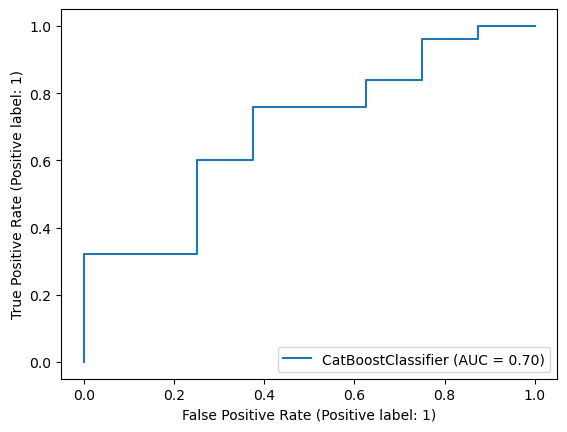

In [25]:
# Performance 
metrics.plot_roc_curve(clf,X_test,y_test)

In [26]:
tr = np.arange(0, 0.9, 0.001)
pr = []
re = []
f1 = []
ac = []
for i in tr:
    y_pp = (y_pred >i).astype(bool)
    pr.append(metrics.precision_score(y_test, y_pp))
    re.append(metrics.recall_score(y_test, y_pp))
    ac.append(metrics.accuracy_score(y_test, y_pp))
    f1.append(metrics.f1_score(y_test, y_pp))

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

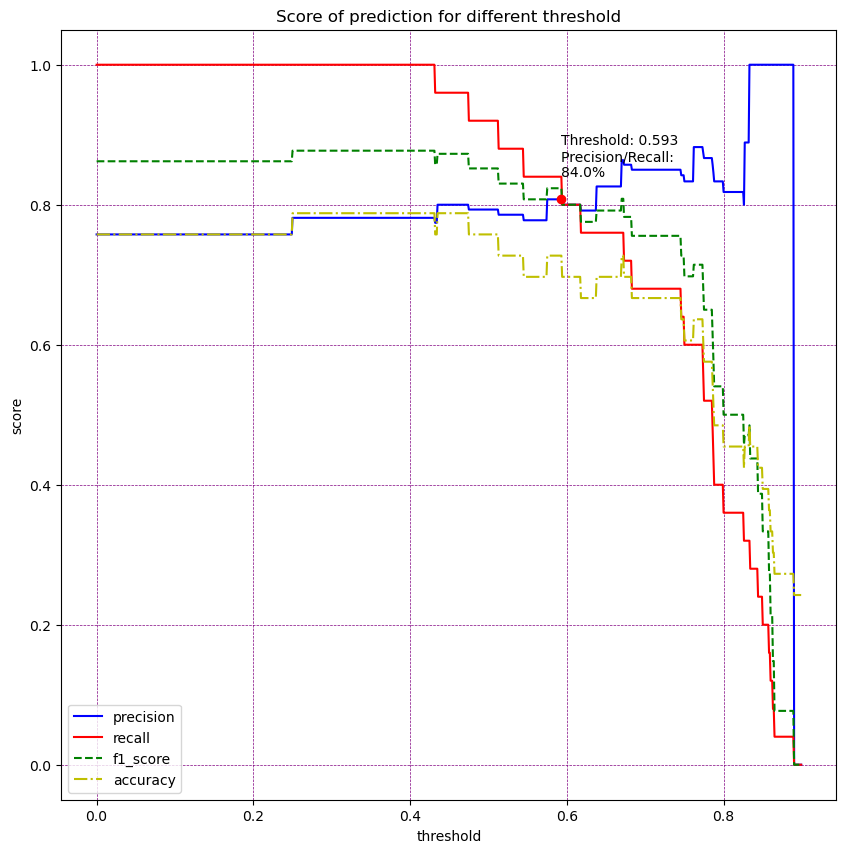

In [27]:
plt.figure(dpi=100, figsize=(10,10))
plt.plot(tr,pr,'b-',tr,re,'r-',tr,f1,'g--',tr,ac,'y-.')
plt.legend(['precision','recall','f1_score','accuracy'])
plt.xlabel('threshold')
plt.ylabel('score')
plt.title('Score of prediction for different threshold')
idx = (np.argwhere(np.diff(np.sign(np.subtract(pr, re)))).flatten())[0]
plt.plot(tr[idx],pr[idx],'ro')
plt.grid(color='purple',linestyle='--', linewidth=0.5)
plt.annotate(f'Threshold: {tr[idx]}\nPrecision/Recall: \n{round(re[idx]*100,2)}%', xy=(tr[idx],re[idx]))
plt.show();

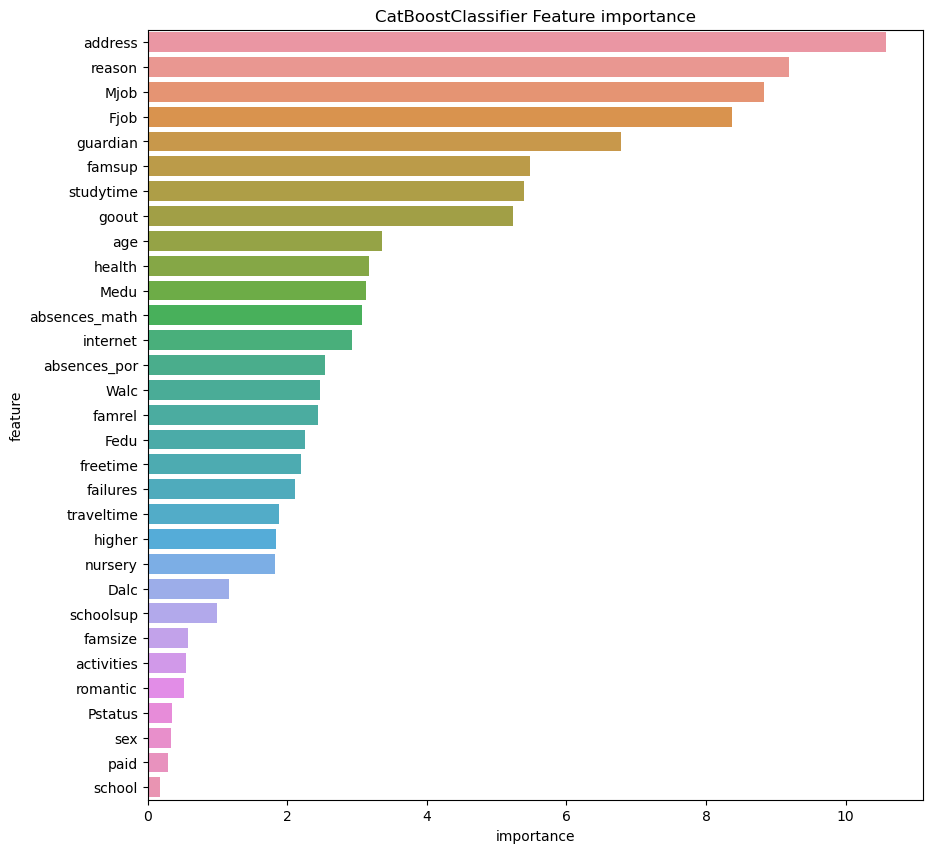

In [28]:
plt.figure(figsize=(10,10),dpi=100)
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('CatBoostClassifier Feature importance')
plt.show()

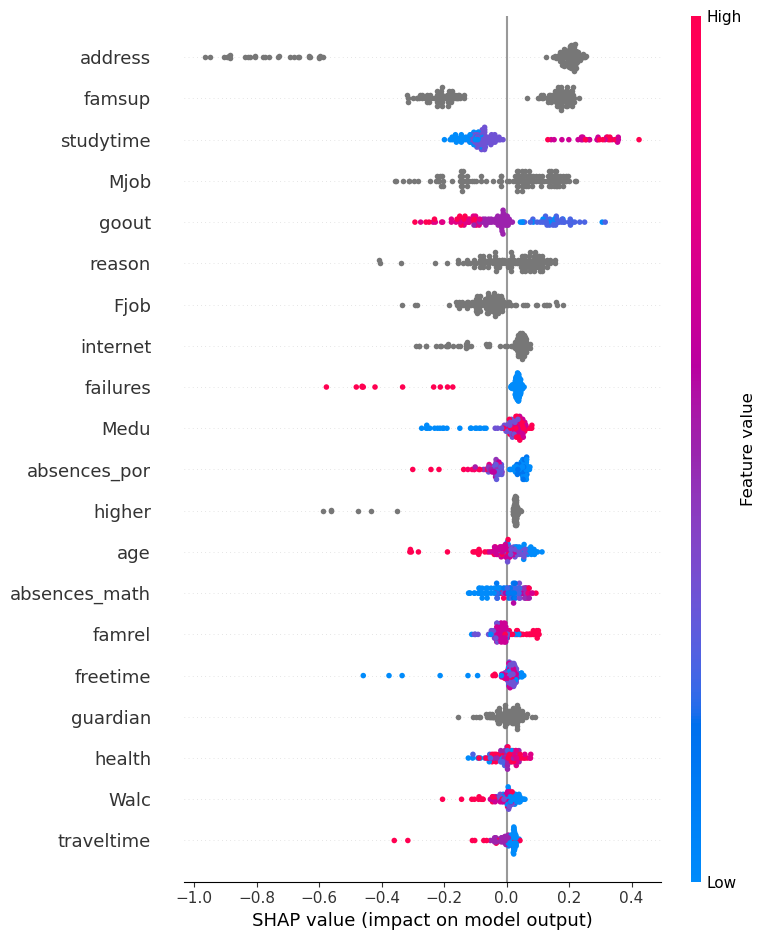

In [29]:
explainer = shap.TreeExplainer(clf)
shape_values = explainer.shap_values(train_data)
shap.summary_plot(shape_values, X_train)